# Reading and formatting the XT data


In [1]:
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from scipy.stats.stats import pearsonr

# OS interaction
import sys
import pickle
import os

# import plotting
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph

# Customize
sns.set_style("whitegrid")
sns.set_context('talk')
%matplotlib inline

# XML
import xmltodict

In [5]:
# --------------------------------------------------------------------------------------------------------------------
# Directory Lists

# Find host name
import socket
if socket.gethostname().find('.')>=0:
    name=socket.gethostname()
else:
    name=socket.gethostbyaddr(socket.gethostname())[0]

# Determine which machine the script is running on; set up directory names
if 'btgmm8' in name:
    dirPre = '/Users/karllapo/Desktop/'
elif 'klapos' in name:
    dirPre = '/Users/karllapo/gdrive/DarkMix/'

dirData = dirPre + 'proj/VertHarpExp2017Kloendeel/data/DTS_XT_VHSRE'
dirPrint = dirPre + 'graphics'
dirProcessed = dirPre + 'proj/VertHarpExp2017Kloendeel/data/DTS_XT_VHSRE_processed'

## Location library for labeling

In [3]:
def labelLocation(ds):

    location = {
        ########################
        ## Near vertical harp ##
        ########################
        # Segment 1, up and over ~ 47.3 to 50.8. 2m vertical separation,
        # tentatively assign 47.3 to 48.5 as the upward limb.
        'vertHarpNear_1': [47.3, 48.5],
        # Segment 2, up and over ~ 47.3 to 50.8. 2m vertical separation,
        # tentatively assign 50.8 to 49.3 as the downward limb.
        'vertHarpNear_2': [49.3, 50.8],
        # Segment 3, up and over ~ 51.5 to 54.9. 2m vertical separation,
        # tentatively assign 51.5 to 53.0 as the upward limb.
        'vertHarpNear_3': [51.5, 53.0],
        # Segment 4, up and over ~ 51.5 to 54.9. 2m vertical separation,
        # tentatively assign 53.4 to 54.9 as the downward limb.
        'vertHarpNear_4': [53.4, 54.9],

        #######################
        ## Far vertical harp ##
        #######################
        # Segment 1, up and over ~ 326.2 to 329.75. 2m vertical separation,
        # tentatively assign 326.2 to 327.7 as the upward limb.
        'vertHarpFar_1': [326.2, 327.7],
        # Segment 2, up and over ~ 326.2 to 329.75. 2m vertical separation,
        # tentatively assign 329.75 to 328.25 as the downward limb.
        'vertHarpFar_2': [328.25, 329.75],
        # Segment 3, up and over ~ 330.4 to 333.75. 2m vertical separation,
        # tentatively assign 330.4 to 331.9 as the upward limb.
        'vertHarpFar_3': [330.4, 331.9],
        # Segment 4, up and over ~ 330.4 to 333.75. 2m vertical separation,
        # tentatively assign 332.25 to 333.75 as the downward limb.
        'vertHarpFar_4': [332.25, 333.75],


        ######################
        ## Horizontal Array ##
        ######################
        'Horizontal - 86cm': [245, 294.5],
        'Horizontal - 84cm': [192.25, 242],
        'Horizontal - 60.5cm': [136, 185.5],
        'Horizontal - 56cm': [82.5, 132],

        #######################
        ## Temperature Baths ##
        #######################
        'warmBathNear': [29, 33],
        'coldBathNear': [17, 22],
        'warmBathFar': [346, 351],
        'coldBathFar': [357, 362],
    }

    # Assign location tags
    ds.coords['location'] = (('LAF'), [None] * ds.LAF.size)
    ds.attrs['locations'] = ';'.join(list(location.keys()))
    for l in location:
        ds.coords['location'].loc[(ds.LAF > location[l][0]) & (ds.LAF < location[l][-1])] = l

    # Assign height values
    locationHeights = {
        'Horizontal - 86cm': 0.86,
        'Horizontal - 84cm': 0.84,
        'Horizontal - 60.5cm': 0.605,
        'Horizontal - 56cm': 0.56,
    }

    return(ds)

# Read XML files

In [6]:
def readDumbXMLFiles(dumbXMLFile):
    with open(dumbXMLFile) as dumb:
        doc = xmltodict.parse(dumb.read())
    
    # Remove all of the bullshit
    doc = doc['logs']['log']
    
    # Extract units/metadata info out of xml dictionary
    metaData = {'LAF_beg': float(doc['startIndex']['#text']),
                'LAF_end': float(doc['endIndex']['#text']),
                'dLAF': float(doc['stepIncrement']['#text']),
                'dt_start': pd.to_datetime(doc['startDateTimeIndex'], infer_datetime_format=True),
                'dt_end': pd.to_datetime(doc['endDateTimeIndex'], infer_datetime_format=True),
                'probe1Temperature': float(doc['customData']['probe1Temperature']['#text']),
                'probe2Temperature': float(doc['customData']['probe2Temperature']['#text']),
                'fiberOK': int(doc['customData']['fibreStatusOk']),
               }

    # Extract data
    data = doc['logData']['data']

    numEntries = np.size(data)
    LAF = np.empty(numEntries)
    Ps = np.empty_like(LAF)
    Pas = np.empty_like(LAF)
    temp = np.empty_like(LAF)

    for dnum, dlist in enumerate(data):
        LAF[dnum], Ps[dnum], Pas[dnum], temp[dnum] = list(map(float, dlist.split(',')))

    actualData = pd.DataFrame.from_dict({'LAF': LAF, 'Ps': Ps, 'Pas': Pas, 'temp': temp}).set_index('LAF')
    
    
    return(actualData, metaData)

procFlag = True
if procFlag:
    # List of files to iterate over
    os.chdir(dirData)
    dirCon = [dC for dC in os.listdir() if 'channel 1' in dC]
    nTotal = np.size(dirCon)
    ds = None

    for nDumb, someDumbFiles in enumerate(dirCon):
        if '.xml' in someDumbFiles:
            print("\r", someDumbFiles + 'File ' + str(nDumb) + ' of ' + str(nTotal), end="")
        else:
            continue

        # Read the file
        df, meta = readDumbXMLFiles(someDumbFiles)

        # Create a temporary xarray Dataset
        temp_Dataset = xr.Dataset.from_dataframe(df)
        temp_Dataset.coords['time'] = meta['dt_start']
        temp_Dataset['probe1Temperature'] = meta['probe1Temperature']
        temp_Dataset['probe2Temperature'] = meta['probe2Temperature']
        temp_Dataset['fiberStatus'] = meta['fiberOK']

        if ds:
            ds = xr.concat([ds, temp_Dataset], dim='time')
        else:
            ds = temp_Dataset

        # Chunking/saving to avoid lock-up
        if np.mod(nDumb + 1, 1000) == 0:
            os.chdir(dirProcessed)
            numChunk = np.floor_divide(nDumb, 1000)
            ds.attrs = {'LAF_beg': meta['LAF_beg'],
                        'LAF_end': meta['LAF_end'],
                        'dLAF': meta['dLAF']}
            ds = labelLocation(ds)
            ds.to_netcdf('VHRSE_chunk' + str(numChunk) + '.nc', 'w')
            ds.close()
            ds = None
            os.chdir(dirData)


 channel 1_20170905152710726.xmlFile 11277 of 11278hannel 1_20170905010848714.xmlFile 3129 of 11278

In [12]:
#########################
## Load processed data ##
#########################
os.chdir(dirProcessed)
ncFiles = ['VHRSE_chunk' + str(nFile) + '.nc' for nFile in np.arange(1, 10)]
ds = xr.open_mfdataset(ncFiles)
ds.attrs['locations'] = ds.attrs['locations'].split(';')

print(ds)
print(np.unique(ds.attrs['locations']))

<xarray.Dataset>
Dimensions:            (LAF: 18579, time: 9000)
Coordinates:
  * LAF                (LAF) float64 -222.9 -222.6 -222.4 -222.1 -221.8 ...
    location           (LAF) object '' '' '' '' '' '' '' '' '' '' '' '' '' ...
  * time               (time) datetime64[ns] 2017-09-04T22:00:26 ...
Data variables:
    Pas                (time, LAF) float64 -0.421 -1.727 -2.897 -3.653 ...
    Ps                 (time, LAF) float64 -1.008 -1.354 -2.164 -3.665 ...
    temp               (time, LAF) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    probe1Temperature  (time) float64 839.5 839.5 839.5 839.5 839.5 839.5 ...
    probe2Temperature  (time) float64 839.5 839.5 839.5 839.5 839.5 839.5 ...
    fiberStatus        (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
Attributes:
    LAF_beg:    -222.866
    LAF_end:    4499.648
    dLAF:       0.254
    locations:  ['vertHarpNear_1', 'vertHarpNear_2', 'vertHarpNear_3', 'vertH...
['Horizontal - 56cm' 'Horizontal - 60.5cm' 'Horizont

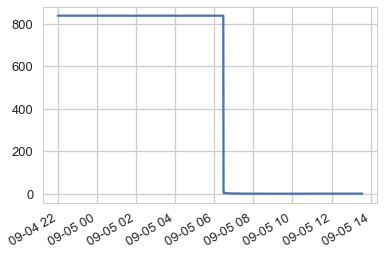

In [15]:
plt.plot(ds.time, ds.probe1Temperature)
plt.gcf().autofmt_xdate()

Ok, looks like we can use the PT100 temperature time seires to index when the XT was running the long cable during the experiment.

Psuedo-code:

expIndex = PT100 temperature < 100

ds = ds where expIndex is True    

In [17]:
###################################################################################################################
# Extract out the XT times when it was managing the full experiment
expIndex = ds.probe1Temperature < 100
print(expIndex)
ds = ds.where(expIndex)
print(ds)

<xarray.DataArray 'probe1Temperature' (time: 9000)>
dask.array<lt, shape=(9000,), dtype=bool, chunksize=(1000,)>
Coordinates:
  * time     (time) datetime64[ns] 2017-09-04T22:00:26 2017-09-04T22:00:31 ...
<xarray.Dataset>
Dimensions:            (LAF: 18579, time: 9000)
Coordinates:
  * LAF                (LAF) float64 -222.9 -222.6 -222.4 -222.1 -221.8 ...
    location           (LAF) object '' '' '' '' '' '' '' '' '' '' '' '' '' ...
  * time               (time) datetime64[ns] 2017-09-04T22:00:26 ...
Data variables:
    Pas                (time, LAF) float64 nan nan nan nan nan nan nan nan ...
    Ps                 (time, LAF) float64 nan nan nan nan nan nan nan nan ...
    temp               (time, LAF) float64 nan nan nan nan nan nan nan nan ...
    probe1Temperature  (time) float64 nan nan nan nan nan nan nan nan nan ...
    probe2Temperature  (time) float64 nan nan nan nan nan nan nan nan nan ...
    fiberStatus        (time) float64 nan nan nan nan nan nan nan nan nan ...
Attrib

## Data quality check
In particular, I'm looking for step losses as these seem like the most probable explanation for why the manual calibration is having issues.

In [6]:
location = {

    ########################
    ## Near vertical harp ##
    ########################
    'vertHarpNear' : [47.3, 54.9],

    #######################
    ## Far vertical harp ##
    #######################
    # Segment 1, up and over ~ 326.2 to 329.75. 2m vertical separation,
    # tentatively assign 326.2 to 327.7 as the upward limb.
    'vertHarpFar': [326.2, 333.75],


    ######################
    ## Horizontal Array ##
    ######################
    'Horizontal - 86cm': [245, 294.5],
    'Horizontal - 84cm': [192.25, 242],
    'Horizontal - 60.5cm': [136, 185.5],
    'Horizontal - 56cm': [82.5, 132],

    #######################
    ## Temperature Baths ##
    #######################
    'warmBathNear': [29, 34],
    'coldBathNear': [17, 22],
    'warmBathFar': [346, 351],
    'coldBathFar': [357, 362],
    }

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in log


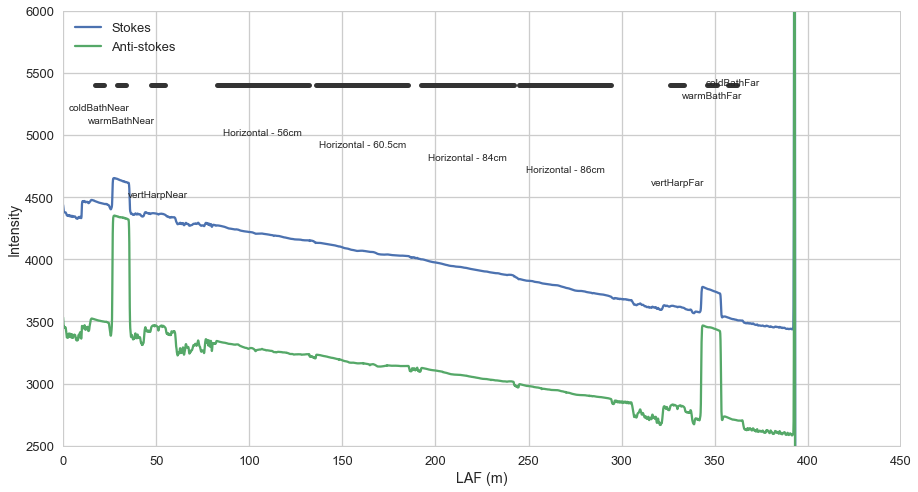

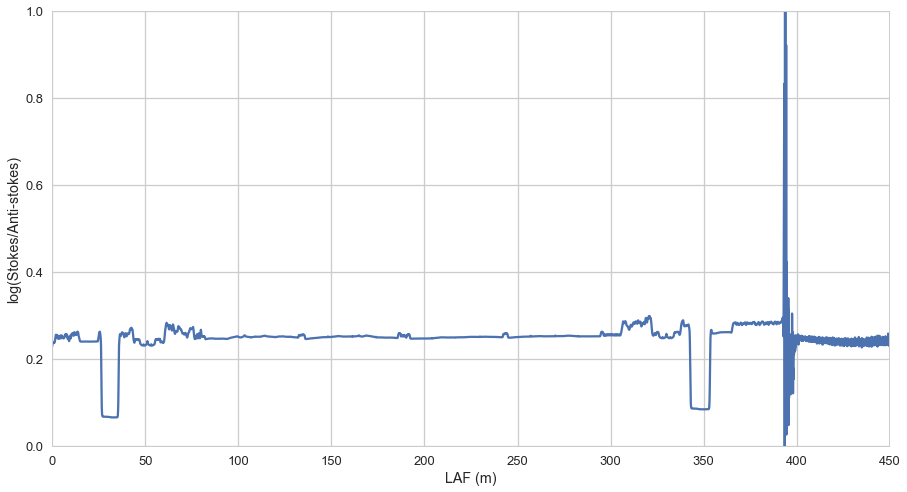

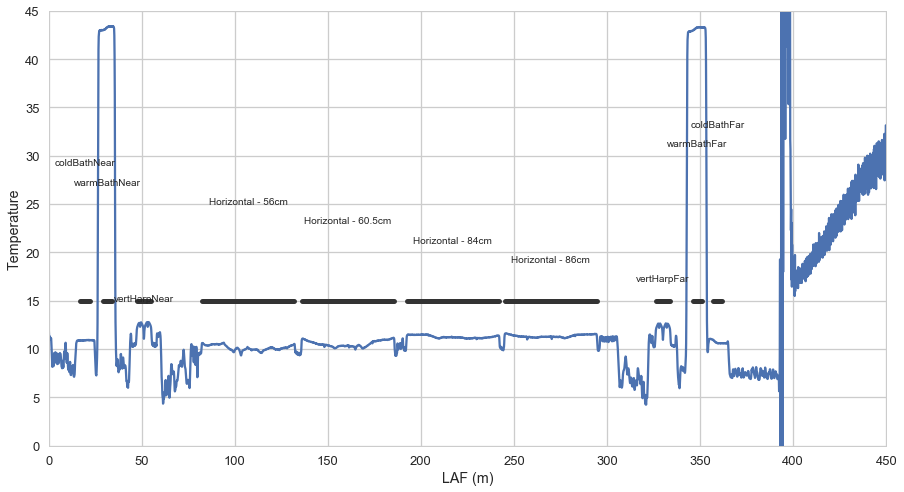

In [7]:
# Stokes and Anti-stokes intensities
startIndex = np.flatnonzero(ds.LAF.values > 0)[0]
plt.figure(figsize=(15, 8))
plt.plot(ds.LAF, ds.Ps.mean(dim='time'), label='Stokes')
plt.plot(ds.LAF, ds.Pas.mean(dim='time'), label='Anti-stokes')

for nl, l in enumerate(location):
    plt.plot([location[l][0], location[l][1]], [5400, 5400], color='0.2', linewidth=5)
    plt.text((location[l][1] + location[l][0]) / 2, 4500 + nl * 100,
             l, horizontalalignment='center')

plt.gca().set_ylim(2500, 6000)
plt.gca().set_ylabel('Intensity')
plt.gca().set_xlabel('LAF (m)')
plt.gca().set_xlim(ds.LAF[startIndex], ds.LAF[-1])
plt.legend()

# Log ratio of stokes:anti-stokes
plt.figure(figsize=(15, 8))
plt.plot(ds.LAF, np.log(ds.Ps / ds.Pas).mean(dim='time'))
plt.gca().set_ylim(0, 1)
plt.gca().set_xlim(ds.LAF[startIndex], ds.LAF[-1])
plt.gca().set_ylabel('log(Stokes/Anti-stokes)')
plt.gca().set_xlabel('LAF (m)')

# Instrument reported temperatures
plt.figure(figsize=(15, 8))
plt.plot(ds.LAF, ds.temp.mean(dim='time'))

for nl, l in enumerate(location):
    plt.plot([location[l][0], location[l][1]], [15, 15], color='0.2', linewidth=5)
    plt.text((location[l][1] + location[l][0]) / 2, 15 + nl * 2,
             l, horizontalalignment='center')

plt.gca().set_ylim(0, 45)
plt.gca().set_xlim(ds.LAF[startIndex], ds.LAF[-1])
plt.gca().set_ylabel('Temperature')
plt.gca().set_xlabel('LAF (m)')



/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log


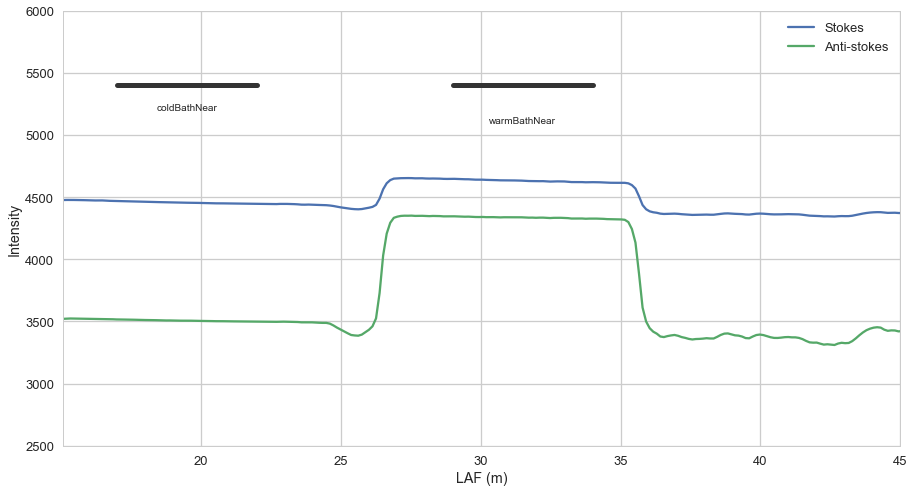

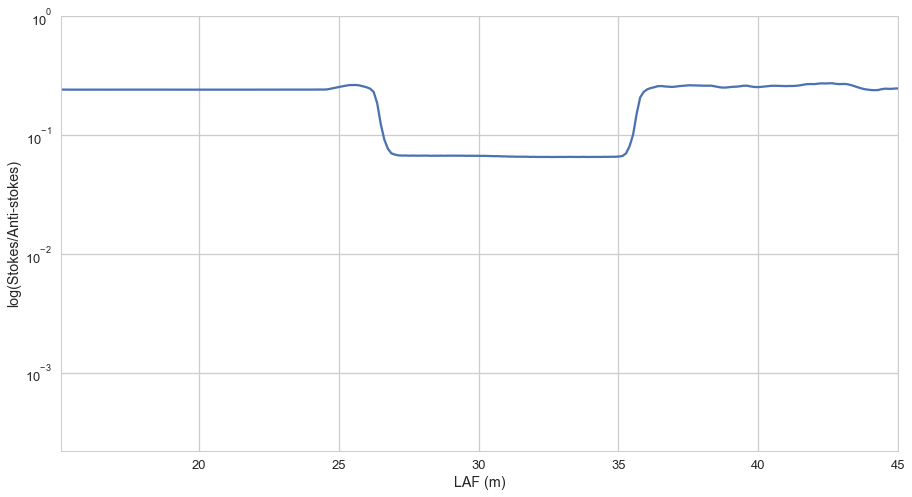

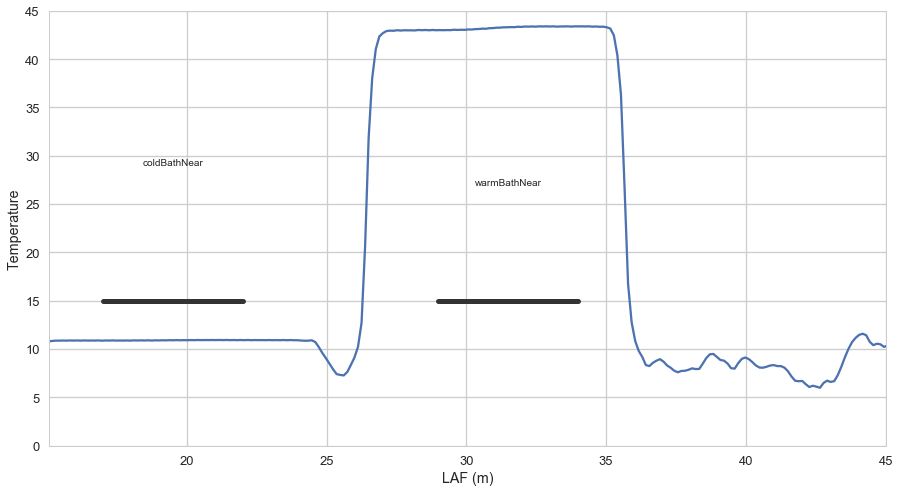

In [9]:
# Stokes and Anti-stokes intensities
startIndex = np.flatnonzero(ds.LAF.values > 15)[0]
plt.figure(figsize=(15, 8))
plt.plot(ds.LAF, ds.Ps.mean(dim='time'), label='Stokes')
plt.plot(ds.LAF, ds.Pas.mean(dim='time'), label='Anti-stokes')

for nl, l in enumerate(location):
    if 'BathNear' not in l:
        continue
    plt.plot([location[l][0], location[l][1]], [5400, 5400], color='0.2', linewidth=5)
    plt.text((location[l][1] + location[l][0]) / 2, 4500 + nl * 100,
             l, horizontalalignment='center')

plt.gca().set_ylim(2500, 6000)
plt.gca().set_ylabel('Intensity')
plt.gca().set_xlabel('LAF (m)')
plt.gca().set_xlim(ds.LAF[startIndex], 45)
plt.legend()

# Log ratio of stokes:anti-stokes
plt.figure(figsize=(15, 8))
plt.semilogy(ds.LAF, np.log(ds.Ps / ds.Pas).mean(dim='time'))
plt.gca().set_ylim(0, 1)
plt.gca().set_xlim(ds.LAF[startIndex], 45)
plt.gca().set_ylabel('log(Stokes/Anti-stokes)')
plt.gca().set_xlabel('LAF (m)')

# Instrument reported temperatures
plt.figure(figsize=(15, 8))
plt.plot(ds.LAF, ds.temp.mean(dim='time'))

for nl, l in enumerate(location):
    if 'BathNear' not in l:
        continue
    plt.plot([location[l][0], location[l][1]], [15, 15], color='0.2', linewidth=5)
    plt.text((location[l][1] + location[l][0]) / 2, 15 + nl * 2,
             l, horizontalalignment='center')

plt.gca().set_ylim(0, 45)
plt.gca().set_xlim(ds.LAF[startIndex], 45)
plt.gca().set_ylabel('Temperature')
plt.gca().set_xlabel('LAF (m)')



Are there step losses? It is not clear to me. (Pardon the terrible labeling, just needed something quick and dirty).

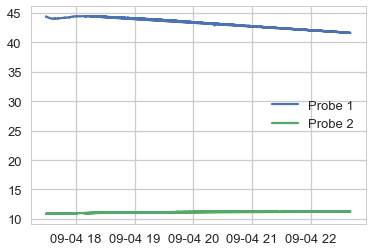

In [18]:
# Temperature probes are unlabeled, determine which bath each was measuring
plt.plot(ds.time, ds['probe1Temperature'], label='Probe 1')
plt.plot(ds.time, ds['probe2Temperature'], label='Probe 2')
plt.legend()

- probe1Temperature is the warm bath
- probe2Temperature is the cold bath

Future versions of read/processing code will somehow need to do affiliate each probe temperature with the bath name for the below calibration to function.

In [11]:
# Reference temperatures
refField1 = 'probe1Temperature' # Warm bath
refField2 = 'probe2Temperature' # Cold bath
refField3 = 'probe1Temperature' # Warm bath

refT1 = ds[refField1]
refT2 = ds[refField2]
refT3 = ds[refField3]

# Reference sections
refLoc1 = 'warmBathFar'
refLoc2 = 'coldBathFar'
refLoc3 = 'warmBathNear'

section1 = ds.swap_dims({'LAF': 'location'}).sel(location=refLoc1)
section2 = ds.swap_dims({'LAF': 'location'}).sel(location=refLoc2)
section3 = ds.swap_dims({'LAF': 'location'}).sel(location=refLoc3)

ref_z1 = section1.LAF.mean(dim='location')
ref_z2 = section2.LAF.mean(dim='location')
ref_z3 = section3.LAF.mean(dim='location')

# Amplitudes of stokes/anti-stokes
stokesRatio1 = np.log(section1.Ps / section1.Pas).mean(dim='location')
stokesRatio2 = np.log(section2.Ps / section2.Pas).mean(dim='location')
stokesRatio3 = np.log(section3.Ps / section3.Pas).mean(dim='location')

# Allocate the calibration variables
gamma = np.ones(np.shape(ds.time.values)) * -9999.
C = np.ones(np.shape(ds.time.values)) * -9999.
delta_alpha = np.ones(np.shape(ds.time.values)) * -9999.

# Within each time step solve for the calibration parameters
for n, t in enumerate(ds.time):
    print("\r", 'Time step ' + str(n) + ' of ' + str(np.size(ds.time.values)), end="")

    
    # A matrix
    A = [[1, -refT1.sel(time=t), refT1.sel(time=t) * ref_z1],
         [1, -refT2.sel(time=t), refT2.sel(time=t) * ref_z2],
         [1, -refT3.sel(time=t), refT3.sel(time=t) * ref_z3],
        ]

    # b matrix
    b = [[refT1.sel(time=t) * stokesRatio1.sel(time=t)],
         [refT2.sel(time=t) * stokesRatio2.sel(time=t)],
         [refT3.sel(time=t) * stokesRatio3.sel(time=t)],
        ]

    x = np.linalg.solve(A, b)
    
    gamma[n] = x[0]
    C[n] = x[1]
    delta_alpha[n] = x[2]

 Time step 15999 of 16000me step 760 of 16000Time step 1787 of 16000Time step 11990 of 16000Time step 13739 of 16000Time step 13926 of 16000

# Calibrated parameters

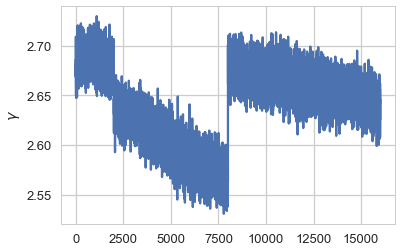

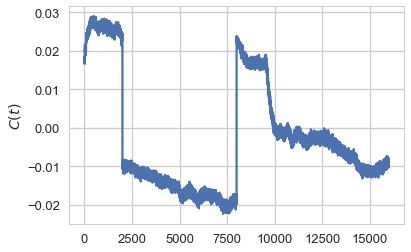

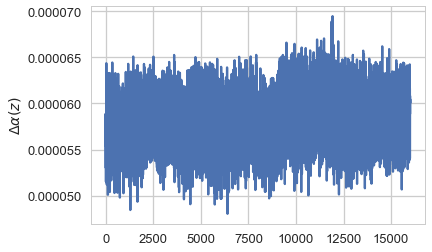

In [12]:
plt.plot(gamma)
plt.gca().set_ylabel('$\gamma$')

plt.figure()
plt.plot(C)
plt.gca().set_ylabel('$C(t)$')

plt.figure()
plt.plot(delta_alpha)
plt.gca().set_ylabel(r'$\Delta  \alpha (z)$')


Ok, the above values are now closer to what we would expect based on literature.
- $\gamma$ is supposed to be stable in both time and space and $O(100)$ (reported value for a different instrument is 400ish). 
- $C$ is expected to vary with time (I think)
- $\Delta \alpha$ is expected to be stable with time, excluding any breaking or bending of the wire. Note: $\Delta \alpha$ is expected to vary along the fiber. Future calibration may want to use an integrated term rather than the assumed constant.

In [13]:
#############################
## Recalculate temperature ##
#############################
manualTemp = np.ones(np.shape(ds.temp.values)) * -9999.

for n, t in enumerate(ds.time):
    print("\r", 'Time step ' + str(n) + ' of ' + str(np.size(ds.time.values)), end="")
    manualTemp[n] = gamma[n] / (np.log(ds.Ps.sel(time=t) / ds.Pas.sel(time=t)) + C[n] - delta_alpha[n] * ds.LAF)
    
ds['manualTemp'] = (('time', 'LAF'), manualTemp)
print(ds)

 Time step 2 of 16000

/anaconda/lib/python3.6/site-packages/dask/array/core.py:476: RuntimeWarning: overflow encountered in true_divide
  o = func(*args, **kwargs)
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  


 Time step 15999 of 16000ime step 6721 of 16000<xarray.Dataset>
Dimensions:            (LAF: 4193, time: 16000)
Coordinates:
  * LAF                (LAF) float64 -83.06 -82.93 -82.8 -82.67 -82.55 ...
    location           (LAF) object '' '' '' '' '' '' '' '' '' '' '' '' '' ...
  * time               (time) datetime64[ns] 2017-09-04T17:29:38 ...
Data variables:
    Pas                (time, LAF) float64 0.1196 -0.9827 13.01 -1.58 -9.542 ...
    Ps                 (time, LAF) float64 -0.7304 1.216 -0.9891 2.12 -11.28 ...
    temp               (time, LAF) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    probe1Temperature  (time) float64 44.38 44.37 44.37 44.37 44.37 44.37 ...
    probe2Temperature  (time) float64 10.88 10.88 10.89 10.88 10.89 10.88 ...
    fiberStatus        (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
    manualTemp         (time, LAF) float64 nan nan nan nan 14.23 3.619 nan ...
Attributes:
    LAF_beg:    -83.055
    dLAF:       0.127
    LAF_end:    449.74

## Spatial evaluation

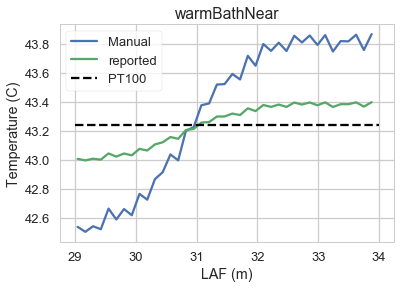

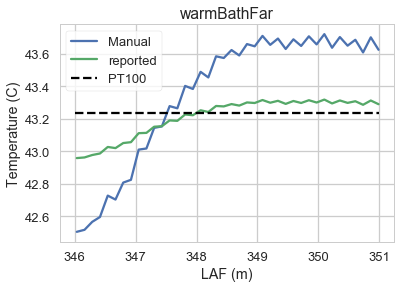

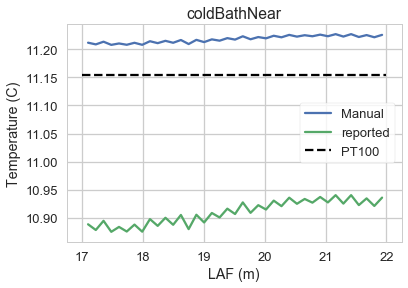

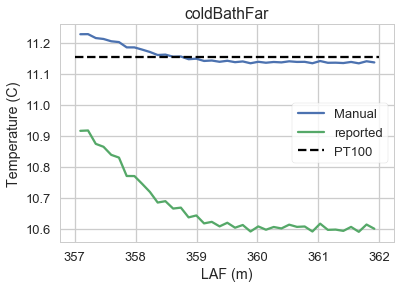

In [14]:
## Near warm bath
loc = 'warmBathNear'
plt.figure()
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='Manual')
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='reported')

probe_ds = ds.probe1Temperature
plt.plot([location['warmBathNear'][0], location['warmBathNear'][1]],
          [probe_ds.mean(dim='time'), probe_ds.mean(dim='time')], 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')
plt.gca().set_xlabel('LAF (m)')

## Far warm bath
loc = 'warmBathFar'
plt.figure()
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='Manual')
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='reported')

probe_ds = ds.probe1Temperature
plt.plot([location[loc][0], location[loc][1]],
          [probe_ds.mean(dim='time'), probe_ds.mean(dim='time')], 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')
plt.gca().set_xlabel('LAF (m)')

## Near cold bath
loc = 'coldBathNear'
plt.figure()
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='Manual')
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='reported')

probe_ds = ds.probe2Temperature
plt.plot([location[loc][0], location[loc][1]],
          [probe_ds.mean(dim='time'), probe_ds.mean(dim='time')], 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')
plt.gca().set_xlabel('LAF (m)')

## Far cold bath
loc = 'coldBathFar'
plt.figure()
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='Manual')
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='reported')

probe_ds = ds.probe2Temperature
plt.plot([location[loc][0], location[loc][1]],
          [probe_ds.mean(dim='time'), probe_ds.mean(dim='time')], 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')
plt.gca().set_xlabel('LAF (m)')


## Temporal evaluation

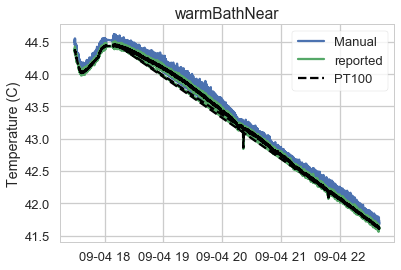

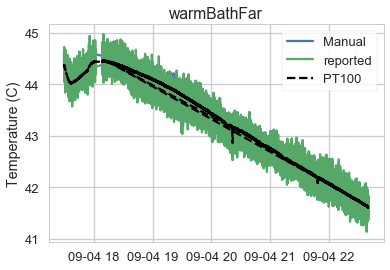

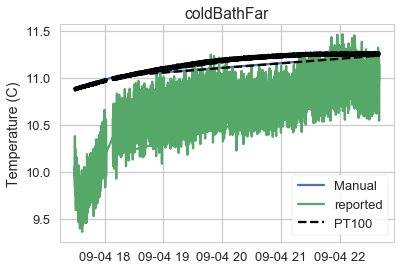

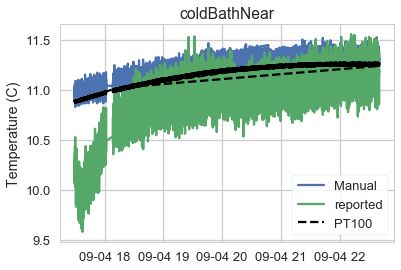

In [15]:
## Near warm bath
loc = 'warmBathNear'
plt.figure()
plt.plot(ds.time, 
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='Manual')
plt.plot(ds.time,
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='reported')

probe_ds = ds.probe1Temperature
plt.plot(probe_ds.time, probe_ds, 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')

## Far warm bath
loc = 'warmBathFar'
plt.figure()
plt.plot(ds.time, 
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='Manual')
plt.plot(ds.time,
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='reported')

probe_ds = ds.probe1Temperature
plt.plot(probe_ds.time, probe_ds, 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')

## Far cold bath
loc = 'coldBathFar'

plt.figure()
plt.plot(ds.time, 
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='Manual')
plt.plot(ds.time,
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='reported')

probe_ds = ds.probe2Temperature
plt.plot(probe_ds.time, probe_ds, 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')

## Near cold bath
loc = 'coldBathNear'

plt.figure()
plt.plot(ds.time, 
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='Manual')
plt.plot(ds.time,
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='reported')

probe_ds = ds.probe2Temperature
plt.plot(probe_ds.time, probe_ds, 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')

# Re-calibrate using different reference sections

Calibration sections:
    - warm bath far
    - cold bath far
    - cold bath near

Validation section:
    - warm bath near

In [16]:
# Reference temperatures
refField1 = 'probe2Temperature' # Cold bath
refField2 = 'probe1Temperature' # Warm bath
refField3 = 'probe2Temperature' # Cold bath

refT1 = ds[refField1]
refT2 = ds[refField2]
refT3 = ds[refField3]

# Reference sections
refLoc1 = 'coldBathFar'
refLoc2 = 'warmBathFar'
refLoc3 = 'coldBathNear'

section1 = ds.swap_dims({'LAF': 'location'}).sel(location=refLoc1)
section2 = ds.swap_dims({'LAF': 'location'}).sel(location=refLoc2)
section3 = ds.swap_dims({'LAF': 'location'}).sel(location=refLoc3)

ref_z1 = section1.LAF.mean(dim='location')
ref_z2 = section2.LAF.mean(dim='location')
ref_z3 = section3.LAF.mean(dim='location')

# Amplitudes of stokes/anti-stokes
stokesRatio1 = np.log(section1.Ps / section1.Pas).mean(dim='location')
stokesRatio2 = np.log(section2.Ps / section2.Pas).mean(dim='location')
stokesRatio3 = np.log(section3.Ps / section3.Pas).mean(dim='location')

# Allocate the calibration variables
gamma = np.ones(np.shape(ds.time.values)) * -9999.
C = np.ones(np.shape(ds.time.values)) * -9999.
delta_alpha = np.ones(np.shape(ds.time.values)) * -9999.

# Within each time step solve for the calibration parameters
for n, t in enumerate(ds.time):
    print("\r", 'Time step ' + str(n) + ' of ' + str(np.size(ds.time.values)), end="")

    
    # A matrix
    A = [[1, -refT1.sel(time=t), refT1.sel(time=t) * ref_z1],
         [1, -refT2.sel(time=t), refT2.sel(time=t) * ref_z2],
         [1, -refT3.sel(time=t), refT3.sel(time=t) * ref_z3],
        ]

    # b matrix
    b = [[refT1.sel(time=t) * stokesRatio1.sel(time=t)],
         [refT2.sel(time=t) * stokesRatio2.sel(time=t)],
         [refT3.sel(time=t) * stokesRatio3.sel(time=t)],
        ]

    x = np.linalg.solve(A, b)
    
    gamma[n] = x[0]
    C[n] = x[1]
    delta_alpha[n] = x[2]
    
#############################
## Recalculate temperature ##
#############################
manualTemp = np.ones(np.shape(ds.temp.values)) * -9999.

for n, t in enumerate(ds.time):
    print("\r", 'Time step ' + str(n) + ' of ' + str(np.size(ds.time.values)), end="")
    manualTemp[n] = gamma[n] / (np.log(ds.Ps.sel(time=t) / ds.Pas.sel(time=t)) + C[n] - delta_alpha[n] * ds.LAF)
    
ds['manualTemp'] = (('time', 'LAF'), manualTemp)
print(ds)

 Time step 2 of 160006000ime step 4060 of 16000Time step 4827 of 16000Time step 6348 of 16000Time step 13866 of 16000

/anaconda/lib/python3.6/site-packages/dask/array/core.py:476: RuntimeWarning: overflow encountered in true_divide
  o = func(*args, **kwargs)
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in log


 Time step 15999 of 16000me step 457 of 16000<xarray.Dataset>
Dimensions:            (LAF: 4193, time: 16000)
Coordinates:
  * LAF                (LAF) float64 -83.06 -82.93 -82.8 -82.67 -82.55 ...
    location           (LAF) object '' '' '' '' '' '' '' '' '' '' '' '' '' ...
  * time               (time) datetime64[ns] 2017-09-04T17:29:38 ...
Data variables:
    Pas                (time, LAF) float64 0.1196 -0.9827 13.01 -1.58 -9.542 ...
    Ps                 (time, LAF) float64 -0.7304 1.216 -0.9891 2.12 -11.28 ...
    temp               (time, LAF) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    probe1Temperature  (time) float64 44.38 44.37 44.37 44.37 44.37 44.37 ...
    probe2Temperature  (time) float64 10.88 10.88 10.89 10.88 10.89 10.88 ...
    fiberStatus        (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
    manualTemp         (time, LAF) float64 nan nan nan nan 13.94 3.598 nan ...
Attributes:
    LAF_beg:    -83.055
    dLAF:       0.127
    LAF_end:    449.746


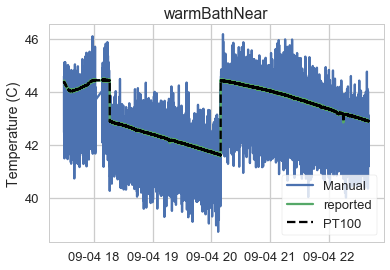

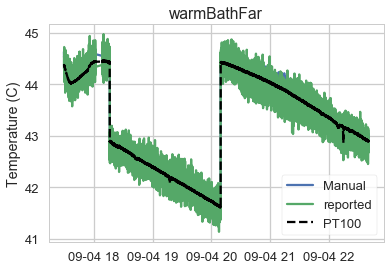

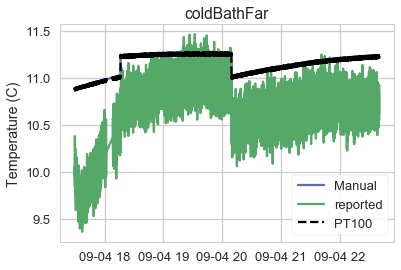

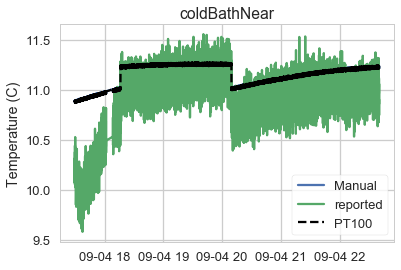

In [25]:
## Near warm bath
loc = 'warmBathNear'
plt.figure()
plt.plot(ds.time, 
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='Manual')
plt.plot(ds.time,
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='reported')

probe_ds = ds.probe1Temperature
plt.plot(probe_ds.time, probe_ds, 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')

## Far warm bath
loc = 'warmBathFar'
plt.figure()
plt.plot(ds.time, 
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='Manual')
plt.plot(ds.time,
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='reported')

probe_ds = ds.probe1Temperature
plt.plot(probe_ds.time, probe_ds, 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')

## Far cold bath
loc = 'coldBathFar'

plt.figure()
plt.plot(ds.time, 
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='Manual')
plt.plot(ds.time,
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='reported')

probe_ds = ds.probe2Temperature
plt.plot(probe_ds.time, probe_ds, 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')

## Near cold bath
loc = 'coldBathNear'

plt.figure()
plt.plot(ds.time, 
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='Manual')
plt.plot(ds.time,
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='reported')

probe_ds = ds.probe2Temperature
plt.plot(probe_ds.time, probe_ds, 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')

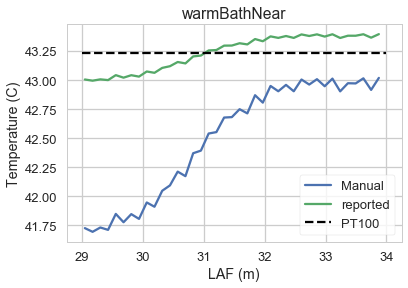

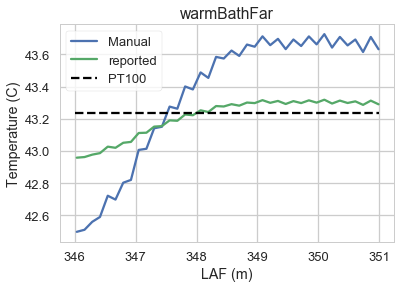

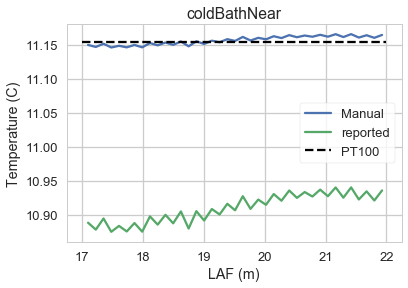

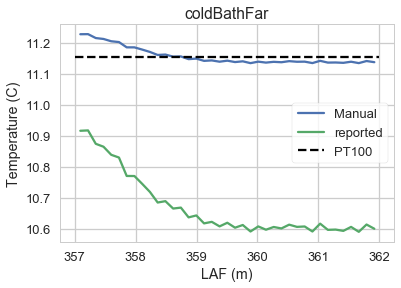

In [19]:
## Near warm bath
loc = 'warmBathNear'
plt.figure()
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='Manual')
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='reported')

probe_ds = ds.probe1Temperature
plt.plot([location['warmBathNear'][0], location['warmBathNear'][1]],
          [probe_ds.mean(dim='time'), probe_ds.mean(dim='time')], 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')
plt.gca().set_xlabel('LAF (m)')

## Far warm bath
loc = 'warmBathFar'
plt.figure()
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='Manual')
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='reported')

probe_ds = ds.probe1Temperature
plt.plot([location[loc][0], location[loc][1]],
          [probe_ds.mean(dim='time'), probe_ds.mean(dim='time')], 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')
plt.gca().set_xlabel('LAF (m)')

## Near cold bath
loc = 'coldBathNear'
plt.figure()
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='Manual')
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='reported')

probe_ds = ds.probe2Temperature
plt.plot([location[loc][0], location[loc][1]],
          [probe_ds.mean(dim='time'), probe_ds.mean(dim='time')], 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')
plt.gca().set_xlabel('LAF (m)')

## Far cold bath
loc = 'coldBathFar'
plt.figure()
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='Manual')
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='reported')

probe_ds = ds.probe2Temperature
plt.plot([location[loc][0], location[loc][1]],
          [probe_ds.mean(dim='time'), probe_ds.mean(dim='time')], 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')
plt.gca().set_xlabel('LAF (m)')


## Evaluations for after the clear offsets and spatial trends are accounted for

In [ ]:
def rmse_ds_time(model, obs):
    return np.sqrt((model - obs) ** 2).mean(dim='time')

def rmse_ds_loc(model, obs):
    return np.sqrt((model - obs) ** 2).mean(dim='location')

loc = 'coldBathNear'
probe_ds = ds.probe2Temperature
error_time = rmse_ds_time(ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc), probe_ds)
error_loc = rmse_ds_loc(ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc), probe_ds.mean(dim='time'))

fig, axes = plt.subplots(2, 1, figsize=(8,8))
axes[0].plot(error_loc)
axes[1].plot(error_time)

loc = 'coldBathFar'
error_time = rmse_ds_time(ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc), probe_ds)
error_loc = rmse_ds_loc(ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc), probe_ds.mean(dim='time'))

fig, axes = plt.subplots(2, 1, figsize=(8,8))
axes[0].plot(error_loc)
axes[1].plot(error_time)

loc = 'warmBathNear'
probe_ds = ds.probe1Temperature
error_time = rmse_ds_time(ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc), probe_ds)
error_loc = rmse_ds_loc(ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc), probe_ds.mean(dim='time'))

fig, axes = plt.subplots(2, 1, figsize=(8,8))
axes[0].plot(error_loc)
axes[1].plot(error_time)

loc = 'warmBathFar'
probe_ds = ds.probe1Temperature
error_time = rmse_ds_time(ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc), probe_ds)
error_loc = rmse_ds_loc(ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc), probe_ds.mean(dim='time'))

fig, axes = plt.subplots(2, 1, figsize=(8,8))
axes[0].plot(error_loc)
axes[1].plot(error_time)

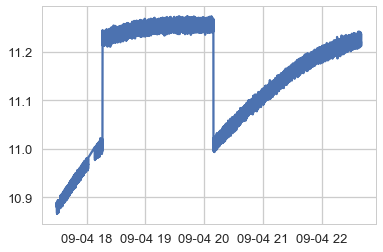

In [28]:
plt.plot(ds.time, ds.probe2Temperature)